In [1]:
import pandas as pd
import numpy as np

import pyodbc
import pandas as pd
import numpy as np
import datetime as dt
import gc
import os
from collections import Counter
import time
from datetime import datetime

class DataLoader:
    def __init__(self, sales_server = r"sql1205pik\db6", sales_database = "DataMart", uid = "11", pwd = "***", trusted_connection="Yes"):
        self.SALES_SERVER = sales_server
        self.SALES_DATABASE = sales_database
        self.UID = uid
        self.PWD = pwd
        self.trusted_connection = trusted_connection
        
    def get_sql_config(self):
        return "DRIVER={SQL Server};Server=" + self.SALES_SERVER + ";DATABASE=" + self.SALES_DATABASE + \
               ";UID=" + self.UID + ";PWD=" + self.PWD + "; Trusted_Connection=" + self.trusted_connection
    
    def load_train(self, cnt = -1):
            sql1 = """select * 
                     from DataMart.dbo.Map_Results_CIANRent
                     """

            sq = pyodbc.connect(self.get_sql_config())
            support = pd.read_sql(sql1, sq)
            return support
        
    def load_heatmap(self, cnt = -1):
            sql1 = """select * 
                     from DataMart.dbo.Map_Results_CIANRent_HeatMap
                     """

            sq = pyodbc.connect(self.get_sql_config())
            support = pd.read_sql(sql1, sq)
            return support
        
    def outload_score(self, df, pred):
        df['Price'] = pred
        sq = pyodbc.connect(self.get_sql_config())
        cursor = sq.cursor()
        df['Flat_CianId'] = df['Flat_CianId'].astype(int)
        df['Date'] = datetime.now().date()
        row = df[['Flat_CianId', 'Price', 'Date']].values.tolist() 
        row = list(map(lambda x: (str(int(x[0])), float(x[1]), str(x[2])), row)) 
        sql= '''insert into DataMart.[dbo].[Map_CIANRent_Predict](CianId, Price, CreateDTM)
                  values(?, ?, ?)'''
        #cursor.fast_executemany = True
        #for each in tqdm_notebook(row):
        try:
            cursor.executemany(sql, row)
            cursor.commit()
        except pyodbc.Error:
            print("Error while writing to DB.")
            print(each)
        cursor.close()
        
    def outload_heatmap(self, df, pred):
        df['Price'] = pred
        sq = pyodbc.connect(self.get_sql_config())
        cursor = sq.cursor()
        df['Flat_CianId'] = df['Flat_CianId'].astype(int)
        df['Date'] = datetime.now().date()
        row = df[['Flat_CianId', 'Price', 'Date']].values.tolist() 
        row = list(map(lambda x: (str(int(x[0])), float(x[1]), str(x[2])), row)) 
        sql= '''insert into DataMart.[dbo].[Map_CIANRent_Predict_HeatMap](CianId, Price, CreateDTM)
                  values(?, ?, ?)'''
        #cursor.fast_executemany = True
        #for each in tqdm_notebook(row):
        try:
            cursor.executemany(sql, row)
            cursor.commit()
        except pyodbc.Error:
            print("Error while writing to DB.")
            print(each)
        cursor.close()

def fillna_Gis(df):
    df = df.copy(deep=True)
    for col in df.columns:
        if "Square" in col:
            df[col] = df[col].fillna(0)
        if "_km" in col:
            df[col] = df[col].fillna(65535)
    return df

In [2]:
res = DataLoader().load_train().drop_duplicates("Flat_comment")

res = fillna_Gis(res)

usless = ['Flat_source', 'Flat_adress', 'Flat_square_rooms', 
          'house_num', 'Flat_comment', 'sale_period', 
          'Flat_house_type', 'floor_finish', 'Flat_sale_type',
         'ipoteka', 'LanLatGeography', 'CoordText', 'CoordYandexText',
         'Flat_date1', 'Flat_create_date', "CoordBuffer500"
      ,'CoordBuffer1000'
      ,'CoordBuffer3000'
      ,'CoordBuffer5000',
      'UpdateDTM', 
      'GIS_Metro_Line',
      'GIS_Metro_Station', 
      'GIS_district', 'Flat_isRentDaily'] + list(filter(lambda x: 'History' in x and "Price" not in x, res.columns))

In [4]:
res = res[res.Flat_isRentDaily == 0].reset_index(drop=True)

In [5]:
res = res.drop(columns = set(usless) & set(res.columns))

C:\Users\rudenkoda\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\rudenkoda\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


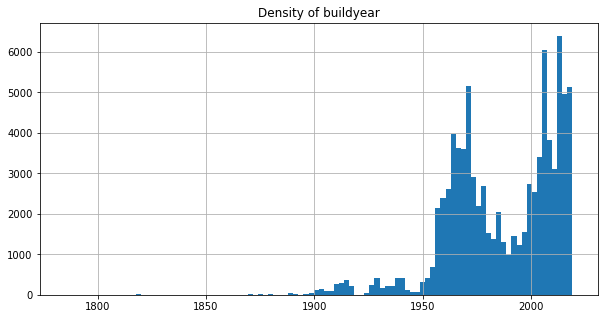

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.grid()
plt.title("Density of buildyear")
_ = plt.hist(res['Flat_build_year'].astype(float), bins=100)


In [8]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
dist = (res['History_LastPrice'].astype(float) / res['Flat_square'].astype(float)).values

dist = dist[dist < np.percentile(dist, q=99)]

In [9]:
from skimage.filters import threshold_otsu

In [10]:
tr = threshold_otsu(dist[dist < 500])

Text(0.5, 1.0, 'm2 rent price with 407.0 threshold')

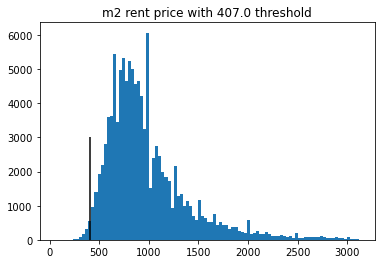

In [11]:
from skimage.filters import threshold_otsu
_ = plt.hist(dist, bins = 100)
plt.vlines(tr, 0, 3000)
plt.title(f"m2 rent price with {np.round(tr)} threshold")

In [12]:
#res = res[res['History_LastPrice'].astype(float) / res['Flat_square'].astype(float) > tr].reset_index(drop=True)

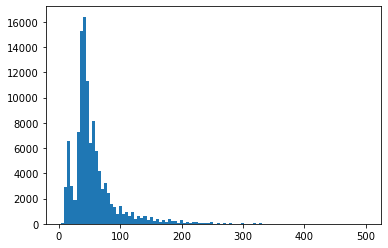

In [13]:
_ = plt.hist(res['Flat_square'].astype(float), bins=100)

In [14]:
res['Flat_square'] = res['Flat_square'].astype(float)

In [15]:
dist = res['Flat_square'].values
tr = threshold_otsu(dist[dist < 40])

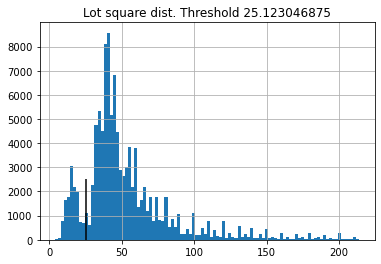

In [16]:
plt.title(f"Lot square dist. Threshold {tr}")
_ = plt.hist(res[res['Flat_square'] < np.percentile(res['Flat_square'].astype(int), 99)]['Flat_square'], bins = 100)
plt.vlines(tr, 0, 2500)
plt.grid()

In [17]:
res = res[res['Flat_square'] > tr].reset_index(drop=True)

In [18]:
res = res.loc[res['Flat_build_year'].astype(float) < 2020]

In [20]:
res = res[res['History_LastPrice'] < np.percentile(res['History_LastPrice'], 95)].reset_index(drop=True)

In [21]:
def preprocess_data(res):
    res['Flat_flat/apart'] = pd.Categorical(res['Flat_flat/apart'])

    res['Flat_build_year'] = res['Flat_build_year'].fillna(res['Flat_build_year'].mode())

    res['Flat_lift'] = res['Flat_lift'].apply(lambda x: 1 if x == 'есть' else 0)

    res['Flat_view'] = pd.Categorical(res['Flat_view'].fillna('unknown'))

    res['Flat_rooms_smeg'] = pd.Categorical(res['Flat_rooms_smeg'].astype(str).fillna("Unknown"))

    res['Flat_station'] = pd.Categorical(res['Flat_station'].astype(str))

    res['Flat_otdelka'] = pd.Categorical(res['Flat_otdelka'], 
                                    categories=['без отд.', 'хор.сост.', 'евр.рем.', 'дизайн.рем.'], 
                                    ordered = True,)

    res['Flat_otdelka'] = res['Flat_otdelka'].fillna('хор.сост.')

    logia_dict = {"Л" : 1, "2Л" : 2, "БЛ" : 1, "3Л" : 3, "Б2Л" : 2, "4Л" : 4, "2Б2Л" : 2, "ЭркЛ" : 1, "*Л" : 1}
    balcony_dict = {"Б" : 1, "2Б" : 2, "БЛ" : 1, "3Б" : 3, "Б2Л" : 1, "3Б" : 3, "2Б2Л" : 2, "*Б" : 1}

    res['Flat_balcony'] = res['Flat_balcon'].map(balcony_dict).fillna(0)
    res['Flat_logia'] = res['Flat_balcon'].map(logia_dict).fillna(0)
    res.drop(columns = ['Flat_balcon'], inplace=True)

    def fillna_minus1(col):
        res[col] = res[col].fillna(-1)

    fillna_minus1('Flat_kitchen_square')
    fillna_minus1('Flat_habitable_square')

    res['Flat_square'] = res['Flat_square'].astype(float)
    res['Flat_kitchen_square'] = res['Flat_kitchen_square'].astype(float)
    res['Flat_habitable_square'] = res['Flat_habitable_square'].astype(float)
    res['Flat_build_year'] = res['Flat_build_year'].astype(float)
    res['Flat_parking'] = pd.Categorical(res['Flat_parking'].astype(str))
    res['Flat_territory_guard'] = pd.Categorical(res['Flat_territory_guard'].astype(str))
    res['Flat_floor'] = res['Flat_floor'].astype(float)
    res['Flat_max_floor'] = res['Flat_max_floor'].astype(float)
    res['Flat_position'] = res['Flat_floor'].astype(float) / res['Flat_max_floor']

    res['GIS_district_Id'] = pd.Categorical(res['GIS_district_Id'])

    res['Flat_to_station_min_cnt'] = res['Flat_to_station_min_cnt'].astype(float, errors = 'ignore')
    res['Flat_to_station_min_cnt'] = res['Flat_to_station_min_cnt'].fillna(np.nan)

    res['Flat_transport_min_metro'] = res['Flat_to_station_min_cnt'].astype(float) * res['Flat_to_station_min_transport'].apply(lambda x: 1 if x == 'т' else 0)
    res['Flat_by_feet_min_metro'] = res['Flat_to_station_min_cnt'] * res['Flat_to_station_min_transport'].apply(lambda x: 1 if x == 'п' else 0)

    res['Flat_by_feet_min_metro'] = res['Flat_by_feet_min_metro'].astype(float, errors = 'ignore')
    res['Flat_by_feet_min_metro'] = res['Flat_by_feet_min_metro'].fillna(np.nan)

    res.drop(columns = ['Flat_to_station_min_cnt', 'Flat_to_station_min_transport'], inplace=True)

    nonseparated_dict = {'С' : 1, '2С' : 2, "3С" : 3, "4С" : 4}
    separated_dict = {'Р' : 1, '2Р' : 2, "3Р" : 3, "4Р" : 4}
    bathrooms = {"С" :     1, "Р": 1, "2" : 2, "2Р" : 2, "2С" : 2, "3" : 3, "-" : 0, "+" : 1, "3Р" : 3, "3С" : 3, "4" : 4, 
                 "4Р" : 4, "4С" : 4}


    res['Flat_nonseparated_dict'] = res['Flat_sanuzel'].map(balcony_dict).fillna(0)
    res['Flat_separated_dict'] = res['Flat_sanuzel'].map(logia_dict).fillna(0)
    res['Flat_bathrooms'] = res['Flat_sanuzel'].map(bathrooms).fillna(0)

    res.drop(columns = ['Flat_sanuzel'], inplace=True)

    res['Flat_spalen'] = res['Flat_spalen'].astype(float).astype(int)

    def Encode_metro_info(data):
        res.drop(columns = ['GIS_House_metro_km'], inplace=True) 
        res['GIS_Metro_Station_Id'] = pd.Categorical(res['GIS_Metro_Station_Id'])
        res['GIS_Metro_Line_Id'] = pd.Categorical(res['GIS_Metro_Line_Id'])
        return data

    res = Encode_metro_info(res)
    
    for each in usless:
        try:
            res.drop(columns=[each], inplace=True)
        except KeyError:
            pass
    return res

In [22]:
res = preprocess_data(res)

In [23]:
cat_columns = res.select_dtypes(['category']).columns

ids = list(filter(lambda x: '_Id' in x, res.columns))

In [24]:
res[list(set(cat_columns).difference(set(ids)))] = res[list(set(cat_columns).difference(set(ids)))].apply(lambda x: x.cat.codes)

In [26]:
# import json
# with open("SecondaryModel\Gis_district_mapping.json", "w") as f:
#     json.dump({name:code for code, name in zip(res['GIS_district'].cat.codes, res['GIS_district'].cat.categories)}, f)

In [25]:
monotone_dict = {'Flat_spalen' : -1, 
                 'Flat_sale_period' : -1, 
                 'Flat_territory_guard' : 1, 
                 'Flat_square' : 0,
                'GIS_isInMKAD' : 1,
                'Flat_height' : 1}

monotone_constraints = [monotone_dict.get(col, 0) for col in res.columns]

def smape(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def smape1(preds, target):
    '''
    Function to calculate SMAPE
    '''
    n = len(preds)
    masked_arr = ~((preds==0)&(target==0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.sum(np.abs(preds-target))
    denom = np.sum(np.abs(preds)+np.abs(target))
    smape_val = num / denom
    return smape_val

def lgbm_smape(preds, train_data):
    '''
    Custom Evaluation Function for LGBM
    '''
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

import lightgbm as lgb
best_params = {
 'subsample_for_bin': 200000,
 'subsample': 0.5,
 #'silent': True,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'random_state': 4545,
 'objective': None,
 'num_leaves': 63,
 'n_jobs': -1,
 'n_estimators': 1000,
 #'monotone_constraints': mon, 
 'min_split_gain': 0.01,
 'min_child_weight': 0.01,
 'min_child_samples': 3,
 #'max_depth': 7,
# 'learning_rate': 0.1,
 'importance_type': 'split',
# 'colsample_bytree': 1.0,
 'boosting_type': 'dart',
    'monotone_constraints' : monotone_constraints
#'bagging_freq' : 1
}

In [26]:
params = best_params
params.pop('monotone_constraints', None)

[0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [27]:
res = res[res['Flat_room/flat'] == 'квартира'].drop(columns = ['Flat_room/flat']).reset_index(drop=True)

C:\Users\rudenkoda\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Best score is 11.296362585042688 on 999 round


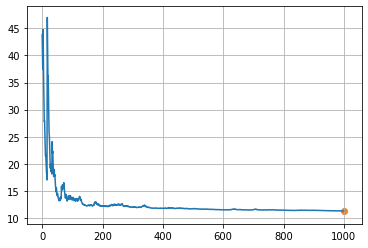

In [54]:
#feature_matrix_filled.columns = [i for i in range(len(feature_matrix_filled.columns))]
cv = lgb.cv(params, train_set=lgb.Dataset(res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).values, label = res['History_LastPrice']), stratified=False, feval = lgbm_smape, nfold = 7)
plt.plot(cv['SMAPE-mean'])
plt.grid()
plt.fill_between(list(range(params['n_estimators'])), np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']), -np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']),alpha=0.3 )
plt.scatter(np.argmin(cv['SMAPE-mean']), np.min(cv['SMAPE-mean']))
print(f"Best score is {np.min(cv['SMAPE-mean'])} on {np.argmin(cv['SMAPE-mean'])} round")

In [28]:
model = lgb.LGBMRegressor(**best_params)

model = model.fit(res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).values, res['History_LastPrice'])

model.booster_.save_model('SecondaryModel\sec_model_rent.txt')

schema = res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).mode().loc[:0]
schema.to_csv("SecondaryModel\modes_rent.csv")

In [29]:
import json
with open("SecondaryModel\model_sec_schema.json", "w") as f:
    json.dump(list(schema.columns), f)

In [37]:
from tqdm import tqdm_notebook
from sklearn.model_selection import KFold
params['n_estimators'] = 5000

pred_df = res.drop(columns=['History_LastPrice']).copy(deep=True).reset_index(drop=True)
predictions = pd.Series(index=pred_df.index, data=0)
y = pd.Series(res['History_LastPrice']).reset_index(drop=True)
sc = pred_df.columns
splits = 10
cv = KFold(n_splits = splits, shuffle = True, random_state= 4545)
for train_idx, test_idx in tqdm_notebook(cv.split(pred_df, y), total = splits):
    model = lgb.LGBMRegressor(**params)
    model = model.fit(pred_df.loc[train_idx].values, y.reset_index(drop=True).loc[train_idx])
    preds = model.predict(pred_df.loc[test_idx])
    predictions.loc[test_idx] = preds
    
pred_df['Price'] = predictions

pred_df['History_LastPrice'] = res['History_LastPrice'].values

row = DataLoader().outload_score(pred_df, predictions)

print(smape(y, predictions))


10.638138205582084


In [ ]:
pred_df['mape'] = np.abs(pred_df['Price'] - pred_df['History_LastPrice']) / pred_df['History_LastPrice']

In [30]:
_ = plt.hist(pred_df['mape'], bins = 100)
thr = np.percentile(pred_df['mape'], q = 95)
plt.vlines(thr, np.min(_[0]), np.max(_[0]))
print(np.percentile(pred_df['mape'], q = 97.5))

NameError: name 'pred_df' is not defined

In [ ]:
dist = (pred_df['Price'] - pred_df['History_LastPrice']).values
dist = dist / np.std(dist)

In [ ]:
_ = plt.hist(dist, bins = 500)
plt.vlines([-3, -2, -1, 1, 2, 3], np.min(_[0]), np.max(_[0]) / 20)


In [ ]:
bad_flats = pred_df[pred_df["mape"] > thr][['Flat_CianId', 'History_LastPrice', 'Price']]['Flat_CianId'].values

In [ ]:
model = lgb.LGBMRegressor(**best_params)
train_df = res[~res['Flat_CianId'].isin(bad_flats)]
x_df = train_df.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).values
y_df = train_df['History_LastPrice'].values
#feature_matrix_filled.columns = [i for i in range(len(feature_matrix_filled.columns))]
cv = lgb.cv(params, train_set=lgb.Dataset(x_df, label = y_df), stratified=False, feval = lgbm_smape, nfold = 7)
plt.plot(cv['SMAPE-mean'])
plt.grid()
plt.fill_between(list(range(params['n_estimators'])), np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']), -np.array(cv['SMAPE-stdv']) + np.array(cv['SMAPE-mean']),alpha=0.3 )
plt.scatter(np.argmin(cv['SMAPE-mean']), np.min(cv['SMAPE-mean']))
print(f"Best score is {np.min(cv['SMAPE-mean'])} on {np.argmin(cv['SMAPE-mean'])} round")

In [101]:
print(f"Best score is {np.min(cv['SMAPE-mean'])} on {np.argmin(cv['SMAPE-mean'])} round")
model = model.fit(x_df, y_df)

model.booster_.save_model('SecondaryModel\sec_model_rent.txt')

schema = train_df.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).mode().loc[:0]
schema.to_csv("SecondaryModel\modes_rent.csv")

Best score is 9.732944460385454 on 4412 round


In [59]:
pred_df[pred_df.Flat_spalen >4].sort_values('mape')[['Flat_CianId', 'mape', 'Price', 'History_LastPrice','Flat_square', 'mape']].tail(50)

Flat_CianId      mape          Price  History_LastPrice  Flat_square  \
20258    214687149  0.187178  201820.296086           170000.0        191.0   
7103     226918199  0.190363  178554.447990           150000.0        120.0   
34032    228073906  0.191001  142920.152554           120000.0        112.0   
6434     230228943  0.191272  202181.943435           250000.0        180.0   
1970     228333864  0.196747  179512.078658           150000.0        227.0   
23758    184882227  0.205317  198670.745087           250000.0        250.0   
20697    229607679  0.211442  220796.180890           280000.0        176.0   
25708    197537703  0.213924  141493.620111           180000.0        120.0   
29066    225072393  0.215627  182344.035224           150000.0        242.0   
28397    217675136  0.218893  195276.628429           250000.0        170.0   
30326    226174508  0.224836  145755.515966           119000.0        150.0   
35233    226894184  0.225574  116429.565170            95000.0        140.0   
19990    224945753  0.235130  191217.508440           250000.0        180.0   
10979    230754236  0.237859  152428.121874           200000.0        162.0   
29435    227645068  0.239885  159624.174305           210000.0        164.0   
26511    227220383  0.242143  189464.209215           250000.0        170.0   
34546    228461482  0.243168  189207.994180           250000.0        154.0   
24641    219820563  0.244441  192667.485004           255000.0        185.0   
2982     197695898  0.246212  150757.641722           200000.0        142.0   
16490    226050480  0.247648  187147.234999           150000.0        224.0   
34506    226694586  0.248038  212166.432254           170000.0        190.0   
21204    204835483  0.252297  150275.606572           120000.0        200.0   
33441    229173663  0.252933  187939.908292           150000.0        240.0   
10777    229232542  0.258590  133453.768416           180000.0        155.0   
7266     218103211  0.272106  190815.907333           150000.0        168.0   
17381    228436748  0.272971  190945.632048           150000.0        265.0   
31366    224989848  0.284266   96624.093516           135000.0        130.0   
17564    230720337  0.290322  198709.954052           280000.0        175.0   
24640    205984947  0.296495  181509.250541           140000.0        195.0   
5689     228748485  0.299111  175222.360127           250000.0        232.0   
33725    226231698  0.303341  234601.423272           180000.0        230.0   
33445    228390866  0.303514  208562.304802           160000.0        178.0   
6165     191299867  0.308439  196265.864551           150000.0        250.0   
20107    228107424  0.323546  211767.361455           160000.0        161.0   
24620    228810263  0.360970  217755.267311           160000.0        178.0   
32858    229114719  0.379674  155081.466219           250000.0        133.0   
11001    227438871  0.381600  176844.768787           128000.0        155.0   
21738    229421109  0.414961  183944.978203           130000.0        180.0   
17185    228721058  0.420517  156256.841756           110000.0        172.0   
14269    224886572  0.445662  149671.177087           270000.0        280.0   
15674    214217412  0.455386  261969.527965           180000.0        155.0   
34881    230888186  0.478084  192150.977212           130000.0        200.0   
13582    227640199  0.497898  112342.317005            75000.0        160.0   
20079    229972000  0.531747  229762.071088           150000.0        205.0   
1584     229034881  0.531838  183820.558852           120000.0        125.0   
20178    228810688  0.591049  238657.292418           150000.0        150.0   
25752    227667003  0.597801  239670.123406           150000.0        250.0   
4751     196195307  0.670089  158658.476173            95000.0        150.0   
29226    228097582  1.034503  183105.255598            90000.0        160.0   
25113    222900723  1.734918  259817.229587            95

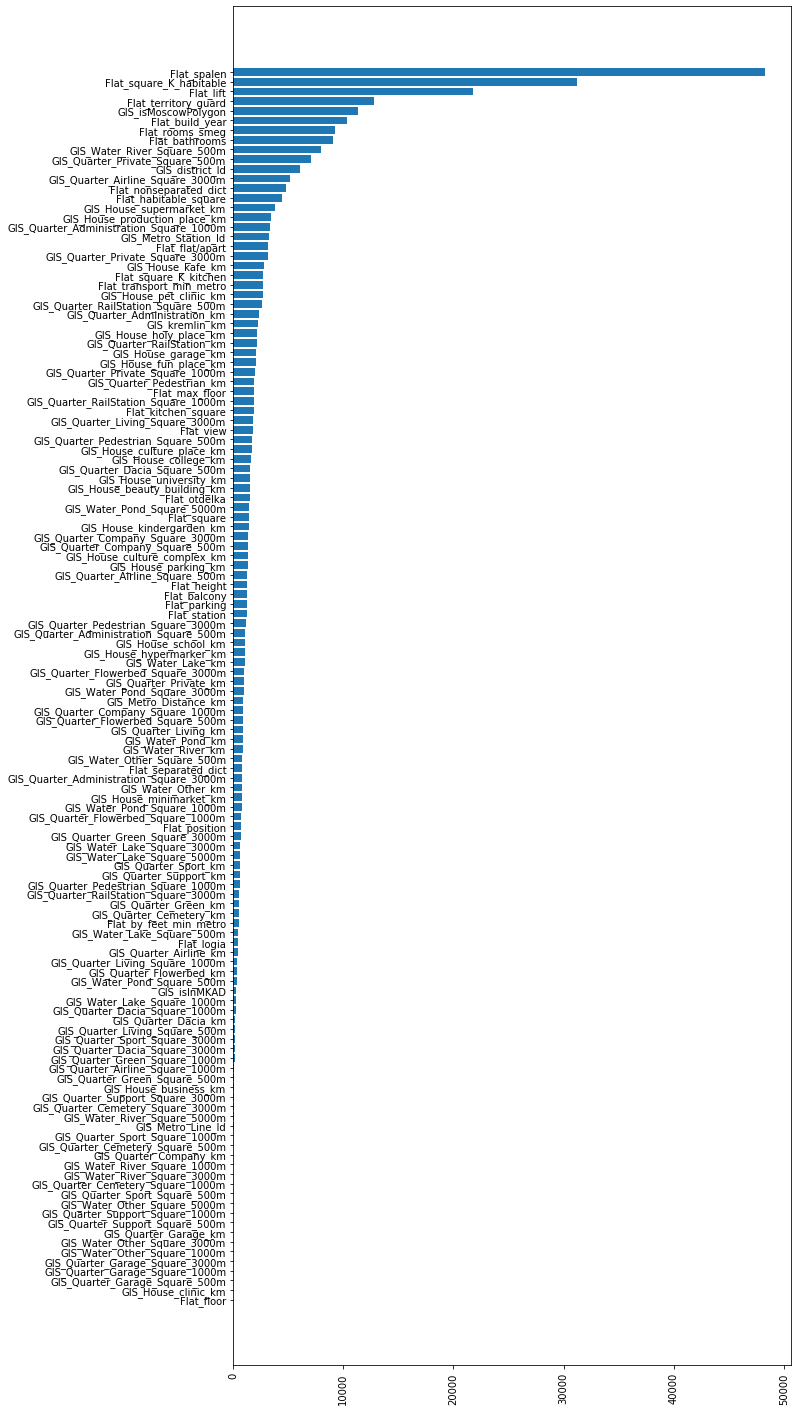

In [192]:
cl, names = zip(*sorted(zip(res.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).columns, model.feature_importances_), key  =lambda x: x[1]))
plt.figure(figsize=(10,25))
_ = plt.barh(cl, names, )
_ = plt.xticks(rotation=90)

In [ ]:
vvv = 2 * np.abs(pred_df['Price'] - pred_df['History_LastPrice'] / pred_df['Flat_square']) / np.abs(pred_df['Price'] + pred_df['History_LastPrice']/ pred_df['Flat_square'])
_ = plt.hist(vvv, bins = 500)
plt.vlines(np.mean(vvv), ymin=0, ymax=4000)
plt.vlines(np.percentile(vvv, q=95), ymin=0, ymax=500, color='red')
plt.title(f"95% Confidence interval is {np.percentile(vvv, q=95)}")

In [ ]:
res['Price'] = np.round(predictions, decimals=-2).astype(float)

In [ ]:
plt.hist(np.round(predictions, decimals=-2), bins=100)
plt.hist(np.round(y), bins=100, alpha=0.5)

In [ ]:
import shap
idx = 91527
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(res.drop(columns=['History_LastPrice']).loc[idx:idx].astype(float))

In [ ]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)

shap.force_plot(explainer.expected_value, shap_values[0,:], res.drop(columns=['History_LastPrice']).loc[idx:idx].astype(float))

In [103]:
heatmap = DataLoader().load_heatmap()

In [104]:
heatmap = preprocess_data(heatmap)

In [105]:
heatmap_pred = model.predict(heatmap[res.columns].drop(columns = ['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']))

In [106]:
DataLoader().outload_heatmap(heatmap, heatmap_pred)

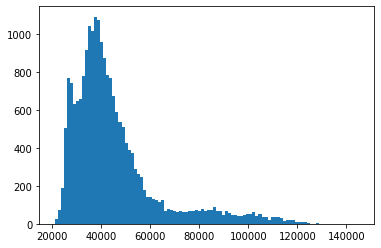

In [108]:
_ = plt.hist(heatmap_pred, bins =100)

In [38]:
temp_h = heatmap[(np.abs(heatmap.Flat_CoordLat - 55.801899) < 0.00001) & (np.abs(heatmap.Flat_CoordLng - 37.493000) < 0.00001)]

In [39]:
temp_h

Flat_CianId  History_LastPrice  Flat_CoordLat  Flat_CoordLng  \
20517    224332902          6500000.0      55.801899         37.493   

       Flat_spalen   Flat_station  Flat_square  Flat_kitchen_square  \
20517            2  Некрасовка м.         38.0                 10.0   

       Flat_habitable_square  Flat_square_K_habitable  ...  Flat_balcony  \
20517                   19.0                      0.5  ...           0.0   

      Flat_logia  Flat_position  Flat_transport_min_metro  \
20517          1       0.117647                       0.0   

      Flat_by_feet_min_metro Flat_nonseparated_dict Flat_separated_dict  \
20517                   15.0                    0.0                 0.0   

      Flat_bathrooms          Price        Date  
20517              1  240753.306192  2020-04-08  

[1 rows x 134 columns]

In [37]:
temp  = res[(np.abs(res.Flat_CoordLat - 55.801899) < 0.00001) & (np.abs(res.Flat_CoordLng - 37.493000) < 0.00001)]
temp['History_LastPrice'] / temp['Flat_square']

108668    188095.214286
108669    181395.348837
108670    204545.454545
136628    179522.727273
136633    180681.818182
136634    180681.818182
136635    171717.391304
dtype: float64

In [43]:
temp.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat'])

Flat_spalen  Flat_station  Flat_square  Flat_kitchen_square  \
108668            2           161         42.0                  6.0   
108669            2           291         43.0                  6.0   
108670            2           161         44.0                  6.0   
136628            2           170         44.0                  6.0   
136633            2           161         44.0                  7.0   
136634            2           161         44.0                  7.0   
136635            2           161         46.0                  7.0   

        Flat_habitable_square  Flat_square_K_habitable  Flat_square_K_kitchen  \
108668                   27.0                 0.642857               0.142857   
108669                   31.0                 0.720930               0.139535   
108670                   34.0                 0.772727               0.136364   
136628                   30.0                 0.681818               0.136364   
136633                   29.0                 0.659091               0.159091   
136634                   29.0                 0.659091               0.159091   
136635                   32.0                 0.695652               0.152174   

        Flat_rooms_smeg  Flat_build_year  Flat_lift  ...  GIS_Metro_Line_Id  \
108668                1           1962.0          0  ...                NaN   
108669                1           1962.0          0  ...                NaN   
108670                2           1962.0          0  ...                NaN   
136628                1           1962.0          0  ...                NaN   
136633                0           1962.0          0  ...                NaN   
136634                0           1962.0          0  ...                NaN   
136635                1           1962.0          0  ...                NaN   

        GIS_district_Id  Flat_balcony  Flat_logia  Flat_position  \
108668              NaN           1.0         0.0            0.4   
108669              NaN           1.0         0.0            0.4   
108670              NaN           1.0         0.0            0.8   
136628              NaN           1.0         0.0            0.4   
136633              NaN           1.0         0.0            1.0   
136634              NaN           1.0         0.0            1.0   
136635              NaN           1.0         0.0            0.4   

        Flat_transport_min_metro  Flat_by_feet_min_metro  \
108668                       0.0                    13.0   
108669                       4.0                     0.0   
108670                       0.0                    15.0   
136628                       0.0                    10.0   
136633                       1.0                     0.0   
136634                       1.0                     0.0   
136635                       0.0                    10.0   

        Flat_nonseparated_dict  Flat_separated_dict  Flat_bathrooms  
108668                     0.0                  0.0             1.0  
108669                     0.0                  0.0             1.0  
108670                     0.0                  0.0             1.0  
136628                     0.0                  0.0             1.0  
136633                     0.0                  0.0             1.0  
136634                     0.0                  0.0             1.0  
136635                     0.0                  0.0             1.0  

[7 rows x 128 columns]

In [47]:
temp_h[temp.drop(columns=['History_LastPrice', 'Flat_CianId', 'Flat_CoordLng', 'Flat_CoordLat']).columns].to_csv("some_shit_delete_it.csv")